# Ensemble Evaluation: Timepoint 1 - Spring 2020

Location: New York State

Timepoint 1: April 3, 2020. Setting: New York State at the beginning of the pandemic when masking was the main preventative measure. No vaccines available. 

Using case and death data for calibration (hospitalization data not available for this timepoint). No vaccination, no variants, and reinfection is not considered.

## Set up for ensemble modeling

### Load dependencies
Import functionality from the pyciemss library to allow for model sampling and calibration.

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyciemss.Ensemble.interfaces import (
    load_and_sample_petri_ensemble, load_and_calibrate_and_sample_ensemble_model
)
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_and_optimize_and_sample_petri_model,
    load_and_calibrate_and_optimize_and_sample_petri_model
)
from pyciemss.visuals import plots
from pyciemss.utils import get_tspan
from pyciemss.utils.interface_utils import cdc_reformatcsv

### Collect relevant models
<!-- We have chosen x number of models to capture the relevant COVID-19 dynamics for this setting. 
 - `model1` contains compartments SEIRHD, and is stratified by age into four groups.
 - `model2` is the same as `model1`, but allows for reinfection
 - `model3` is the same as `model1`, but with a variation in transmission rate to account for masking efficacy and compliance. -->

In [8]:
from mira.sources.askenet import model_from_url
model1 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_ee.json')
model2 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v2.json')
model3 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v3.json')

### Gather data, and set training and forecast intervals
For this timepoint, only case and death data is available for calibration. 

We take the total population of New York State to be 19,340,000. Population age-structure estimates for New York State were taken (and scaled appropriately) from [here](https://www.health.ny.gov/statistics/vital_statistics/2016/table01.htm).

First recorded case in New York State: March 1, 2020.

Also relevant is that a statewide stay-at-home order for non-essential workers was implemented on March 22, 2020, and masking policy was implemented on April 15, 2020. A nice list of COVID-19 policy interventions for New York City and State has been compiled [here](https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986![image.png](attachment:d380d245-11ca-41f1-9863-e2a2dcf5ebce.png)![image.png](attachment:b30f6e31-bc7f-43a8-b7c8-b1df78db3b86.png)![image.png](attachment:b5109588-59ed-447c-9271-50eb56fe9081.png)![image.png](attachment:2c42138a-696d-4cef-9b79-4843d38ff029.png)).

### Define a function to process the source data and produce the necessary datasets for plotting and calibration

In [9]:
def data_selector_function(data_df, train_start_row_num, train_end_row_num, forecast_end_row_num):
    '''
    This function produces three datasets: all_data, all_data1, train_data.
    '''
    all_data = data_df[train_start_row_num:forecast_end_row_num].reset_index()
    all_data = all_data.drop(columns="timestep")
    all_data = all_data.drop(columns="index")

    all_data1 = data_df[train_end_row_num:forecast_end_row_num].reset_index()
    all_data1 = all_data1.drop(columns="timestep")
    all_data1 = all_data1.drop(columns="index")

    train_data = data_df[train_start_row_num:train_end_row_num].reset_index(drop=True)
    train_data1 = train_data.assign(timepoints=[float(i) for i in range(len(train_data))])
    train_data = train_data1[["timepoints", "I", "E", "H", "D"]]

    num_timepoints = (len(train_data) + len(all_data1))*10 + 1
    simulation_timepoints = list(get_tspan(0, (len(train_data) + len(all_data1)), num_timepoints).detach().numpy())
    
    return all_data, all_data1, train_data, simulation_timepoints

### Gather source data and set `DATA_PATH`, `RESULTS_PATH`

In [10]:
url = 'https://raw.githubusercontent.com/DARPA-ASKEM/experiments/main/thin-thread-examples/milestone_12month/evaluation/ensemble_eval_SA/datasets/aabb3684-a7ea-4f60-98f1-a8e673ad6df5/dataset.csv'
nys_data = pd.read_csv(url)
nys_data["E"] = np.nan # Add empty "E" column so that "exposed" may be used to post-process results

DATA_PATH = "../../notebook/ensemble_eval_sa/datasets/"
RESULTS_PATH = "../../notebook/ensemble_eval_sa/ensemble_results/"

### Create and save datasets and simulation timepoints for each forecast

In [11]:
### Forecast 1: 04/03/2020 - 05/01/2020, data: 03/01/2020 - 04/02/2020

# Forecast 1: 04/03/2020 (day 32, row 73) - 05/01/2020 (day 60, row 101), train data: 03/01/2020 (day 0, row 40) - 04/02/2020 (day 31, row 72)
[all_data1, all_data11, train_data1, timepoints1] = data_selector_function(nys_data, 39, 72, 101)
train_data1[["I", "E", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast1.csv")

### Forecast 2: 04/10/2020 - 05/08/2020, data: 03/01/2020 - 04/09/2020

# Forecast 2: 04/10/2020 (day 39, row 80) - 05/08/2020 (day 67, row 108), train data: 03/01/2020 (day 0, row 40) - 04/09/2020 (day 38, row 79)
[all_data2, all_data12, train_data2, timepoints2] = data_selector_function(nys_data, 39, 79, 108)
train_data2[["I", "E", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast2.csv")

### Forecast 3: 04/17/2020 - 05/15/2020, data: 03/01/2020 - 04/16/2020

# Forecast 3: 04/17/2020 (day 46, row 87) - 05/15/2020 (day 74, row 115), train data: 03/01/2020 (day 0, row 40) - 04/16/2020 (day 45, row 86)
[all_data3, all_data13, train_data3, timepoints3] = data_selector_function(nys_data, 39, 86, 115)
train_data3[["I", "E", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast3.csv")

### Forecast 4: 04/24/2020 - 05/22/2020, data: 03/01/2020 - 04/23/2020

# Forecast 3: 04/24/2020 (day 53, row 94) - 05/22/2020 (day 81, row 122), train data: 03/01/2020 (day 0, row 40) - 04/23/2020 (day 52, row 93)
[all_data4, all_data14, train_data4, timepoints4] = data_selector_function(nys_data, 39, 93, 122)
train_data4[["I", "E", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast4.csv")

### Plot the data

Text(0.5, 1.0, 'Cumulative Deaths per 100,000')

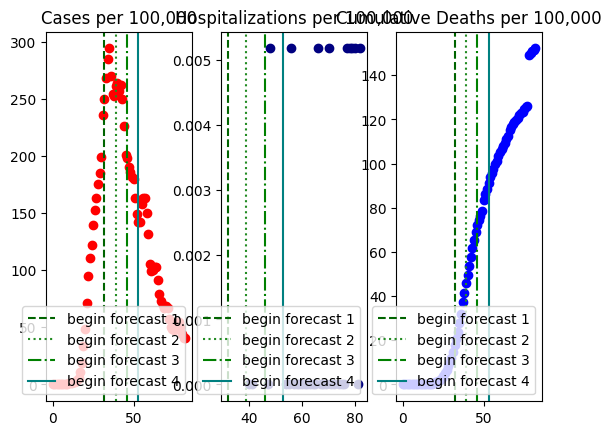

In [12]:
N = 19_340_000

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# ax1.scatter(all_data4.index, all_data4.I, color="red")
ax1.scatter(all_data4.index, 100000*(all_data4.I/N), color="red")
ax1.axvline(x = 32, color = 'darkgreen', linestyle ="--", label = 'begin forecast 1')
ax1.axvline(x = 39, color = 'forestgreen', linestyle =":", label = 'begin forecast 2')
ax1.axvline(x = 46, color = 'green', linestyle ="-.", label = 'begin forecast 3')
ax1.axvline(x = 53, color = 'teal', label = 'begin forecast 4')
ax1.legend(loc='lower right')
# ax1.set_title("Cases")
ax1.set_title("Cases per 100,000")

# ax2.scatter(all_data4.index, all_data4.H, color="navy")
ax2.scatter(all_data4.index, 100000*(all_data4.H/N), color="navy")
ax2.axvline(x = 32, color = 'darkgreen', linestyle ="--", label = 'begin forecast 1')
ax2.axvline(x = 39, color = 'forestgreen', linestyle =":", label = 'begin forecast 2')
ax2.axvline(x = 46, color = 'green', linestyle ="-.", label = 'begin forecast 3')
ax2.axvline(x = 53, color = 'teal', label = 'begin forecast 4')
ax2.legend(loc='lower right')
# ax2.set_title("Hospitalizations")
ax2.set_title("Hospitalizations per 100,000")

# ax3.scatter(all_data4.index, all_data4.D, color="blue")
ax3.scatter(all_data4.index, 100000*(all_data4.D/N), color="blue")
ax3.axvline(x = 32, color = 'darkgreen', linestyle ="--", label = 'begin forecast 1')
ax3.axvline(x = 39, color = 'forestgreen', linestyle =":", label = 'begin forecast 2')
ax3.axvline(x = 46, color = 'green', linestyle ="-.", label = 'begin forecast 3')
ax3.axvline(x = 53, color = 'teal', label = 'begin forecast 4')
ax3.legend(loc='lower right')
# ax3.set_title("Cumulative Deaths")
ax3.set_title("Cumulative Deaths per 100,000")

# (1) Forecast 1: 04/03/2020 - 05/01/2020

## (A) Calibrate and sample an ensemble of one model

In [13]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Apr032020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Apr032020.csv"
N_ITERATIONS = 26

### MODEL 1 - SEIRHD with NPI of Type 1

In [9]:
num_samples = 100
models = [model1]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "I", "E": "E", "H": "H", "D": "D"}]

# Run the calibration and sampling
result1A1 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A1["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 734.1913857460022
iteration 25: loss = 702.8748047351837



### Post-process results

In [40]:
# Define functions to get incident cases, hospitalizations, and deaths
def get_incident_cases(x, y): # delta * Exposed
    return x * y

def get_incident_hosp(x, y, z): # eta * gamma * Infectious
    return x * y * z

def get_incident_deaths(x, y, z): # (mu/los) * Hospitalized
    return (x/y) * z

In [ ]:
# make a dictionary of strings to torch tensors that can be transformed using convert_to_output_format

In [16]:
# Save results
results_df = result1A1["data"]

# Format quantiles
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases(row['model_0/delta_param'], row['E_sol']), axis=1)
results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp(row['model_0/eta_param'], row['model_0/gamma_param'], row['I_sol']), axis=1)
results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths(row['model_0/mu_param'], row['model_0/los_param'], row['H_sol']), axis=1)
results_df.to_csv(RESULTS_FILENAME, index=False)

result1A1["quantiles"].to_csv(QUANTILES_FILENAME, index=False)

q_ensemble_data = cdc_reformatcsv(filename=QUANTILES_FILENAME, 
                                  solution_string_mapping={"I": "case_census", "E": "Exposed", "H": "hosp_census", "D": "cumul_deaths", "Incident_Cases": "Incident_Cases", "Incident_Hosp": "Incident_Hosp", "Incident_Deaths": "Incident_Deaths"}, 
                                  forecast_start_date="2020-04-03",
                                  location="New York State",
                                  drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
q_ensemble_data.to_csv(QUANTILES_FILENAME)

## PREVIOUS WAY OF PROCESSING QUANTILES
# q_ensemble_data = cdc_reformatcsv(filename="../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", 
#                                   solution_string_mapping={"I": "cases", "D": "deaths"}, 
#                                   forecast_start_date="2020-04-02",
#                                   location="New York State",
#                                   drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
# q_ensemble_data.to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_forecast_quantiles_Apr032020.csv")

NameError: name 'result1A1' is not defined

### MODEL 2 - Age-Structured SEIRHD with NPI of Type I, Model Version 2

In [14]:
num_samples = 100
models = [model2]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result1A2 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result1A2["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result1A2["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A2["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 761.4752381145954
iteration 25: loss = 743.8496415913105



### Post-process results

In [ ]:
result1A2["data"]

### MODEL 3 - Age-Structured SEIRHD with NPI of Type I, Model Version 3

In [39]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result1A3 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result1A3["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result1A3["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A3["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 757.8056801855564
iteration 25: loss = 731.8724491894245
iteration 50: loss = 698.796661645174
iteration 75: loss = 685.029021769762
iteration 100: loss = 683.2341018021107
iteration 125: loss = 680.6482000648975
iteration 150: loss = 680.3660717308521
iteration 175: loss = 678.2488649189472
iteration 200: loss = 682.0087104141712
iteration 225: loss = 681.5114467442036
iteration 250: loss = 682.4945268929005
iteration 275: loss = 677.4586117565632
iteration 300: loss = 679.1927147209644
iteration 325: loss = 678.027965337038
iteration 350: loss = 679.7525301277637
iteration 375: loss = 680.8988595306873



### Post-process and save results

In [ ]:
result1A3["data"]

## (B) Calibrate and sample an ensemble of multiple models

In [35]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Apr042020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Apr042020.csv"
N_ITERATIONS = 400

In [36]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result1B1 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result1B1["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result1B1["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# q_ensemble_data = cdc_reformatcsv(filename="../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", 
#                                   solution_string_mapping={"I": "cases", "D": "deaths"}, 
#                                   forecast_start_date="2020-04-02",
#                                   location="New York State",
#                                   drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
# q_ensemble_data.to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_forecast_quantiles_Apr032020.csv")

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B1["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 782.995057284832
iteration 25: loss = 718.4326049685478
iteration 50: loss = 705.7758602499962
iteration 75: loss = 699.6395545601845
iteration 100: loss = 693.8641675114632
iteration 125: loss = 687.1432582736015
iteration 150: loss = 684.5463476777077
iteration 175: loss = 686.4409964680672
iteration 200: loss = 682.3428602814674
iteration 225: loss = 679.0653240084648
iteration 250: loss = 682.2120304703712
iteration 275: loss = 677.2048196196556
iteration 300: loss = 677.0063019394875
iteration 325: loss = 682.8766835331917
iteration 350: loss = 677.7713041901588
iteration 375: loss = 679.8981911540031



In [ ]:
num_samples = 100
models = [model1, model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result1B2 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result1B2["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_two_results.csv", index=False)
# result1B2["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_two_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B2["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [38]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [0.1, 0.4, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result1B3 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result1B3["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result1B3["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B3["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 804.4746714234352
iteration 25: loss = 758.4989128708839
iteration 50: loss = 710.423074066639
iteration 75: loss = 702.4878568053246
iteration 100: loss = 691.4159978032112
iteration 125: loss = 690.3773096203804
iteration 150: loss = 689.6964944005013
iteration 175: loss = 683.8688556551933
iteration 200: loss = 686.3136246800423
iteration 225: loss = 686.1825805306435
iteration 250: loss = 694.1939728856087
iteration 275: loss = 684.0378820300102
iteration 300: loss = 679.3578069806099
iteration 325: loss = 676.0005005002022
iteration 350: loss = 677.4383652806282
iteration 375: loss = 681.9637114405632



In [37]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result1B4 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result1B4["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result1B4["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B4["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 797.0279139876366
iteration 25: loss = 756.8179387450218
iteration 50: loss = 705.6806570887566
iteration 75: loss = 694.8508037924767
iteration 100: loss = 693.0432439446449
iteration 125: loss = 687.104609310627
iteration 150: loss = 684.7172189354897
iteration 175: loss = 685.4249605536461
iteration 200: loss = 695.4806576371193
iteration 225: loss = 685.4759920239449
iteration 250: loss = 686.3081745505333
iteration 275: loss = 681.1065190434456
iteration 300: loss = 685.1855543255806
iteration 325: loss = 681.7464800477028
iteration 350: loss = 681.7984065413475
iteration 375: loss = 677.6978484988213



# (2) Forecast 2: 04/10/2020 - 05/08/2020

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T1_forecast2.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result2A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints2,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result2A["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result2A["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2A["data"]), keep=".*_sol",
                            points=all_data2.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Apr102020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Apr102020.csv"

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast2.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result2B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints2,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result2B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result2B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2B["data"]), keep=".*_sol",
                            points=all_data2.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Apr102020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Apr102020.csv"

# (3) Forecast 3: 04/17/2020 - 05/15/2020

## (A) Calibrate and sample an ensemble of one model

In [15]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T1_forecast3.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result3A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints3,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result3A["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result3A["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3A["data"]), keep=".*_sol",
                            points=all_data3.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 1242.3018300831318
iteration 25: loss = 1173.430355578661



### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Apr172020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Apr172020.csv"

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast3.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result3B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints3,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result3B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result3B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3B["data"]), keep=".*_sol",
                            points=all_data3.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Apr172020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Apr172020.csv"

# (4) Forecast 4: 04/24/2020 - 05/22/2020

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T1_forecast4.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result4A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints4,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result4A["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result4A["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4A["data"]), keep=".*_sol",
                            points=all_data4.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Apr242020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Apr242020.csv"

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast4.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result4B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints4,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result4B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result4B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4B["data"]), keep=".*_sol",
                            points=all_data4.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Apr242020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Apr242020.csv"